<a href="https://colab.research.google.com/github/VadimDu/Protein_LLM_modeling/blob/main/clean_ver_Modeling_ESM_plusplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Synthyra/ESMplusplus_large protein LLM
ESM-plus-plus is a more effienct and Huggingface-compatibile implementation of the new ESM3 (ESM-C)LLM for protein embeddings.

The cells below will be implemented via HuggingFace libraries and advanced wrapper scripts of the latest ESM models, inc. the newly relased ESM3 (ESM-C).

The code and models below are obtained from [HuggingFace/Synthyra/ESMplusplus_large](https://huggingface.co/Synthyra/ESMplusplus_large) repo, which corresponds to the large version of 600 million parameter ESM-C model.

ESM++ is a faithful implementation of ESMC (license) that allows for batching and standard Huggingface compatibility without requiring the ESM Python package.

According to the authors this 600M parameter ESM-C model rivals the 3B parameter ESM2 and approaches the capabilities of the 15B model, delivering frontier performance with far greater efficiency (in terms of computational speed  & resources).

The code below is obtain from [modeling_esm_plusplus.py](https://huggingface.co/Synthyra/ESMplusplus_large/blob/main/modeling_esm_plusplus.py) that suppose to be a general code for various downstream supervised classification tasks.

## Imports and env. variables

In [1]:
"""
ESM++ model implementation.

ESM++ is a faithful implementation of ESMC that allows for batching and standard Huggingface compatibility
The ESM Python package is not required

Modified from https://github.com/evolutionaryscale/esm
License: https://www.evolutionaryscale.ai/policies/cambrian-non-commercial-license-agreement
"""

import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from functools import cache, partial
from pathlib import Path
from typing import Optional, Tuple, Union
from einops import rearrange, repeat
from huggingface_hub import snapshot_download
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.processors import TemplateProcessing
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import PreTrainedModel, PreTrainedTokenizerFast, PretrainedConfig
from transformers.modeling_outputs import ModelOutput

## Configuration class for ESM++ model, multi-head with rotary position embeddings, transformer & ffn layers, output types

In [ ]:
class ESMplusplusConfig(PretrainedConfig):
    """Configuration class for ESM++ model.

    Args:
        vocab_size: Size of the vocabulary
        hidden_size: Dimension of hidden layers
        num_attention_heads: Number of attention heads
        num_hidden_layers: Number of transformer layers
        num_labels: Number of output labels for classification
        problem_type: Type of problem - regression, single/multi label classification
    """
    model_type = "ESMplusplus"
    def __init__(
        self,
        vocab_size: int = 64,
        hidden_size: int = 960,
        num_attention_heads: int = 15,
        num_hidden_layers: int = 30,
        num_labels: int = 2,
        problem_type: str | None = None,
        dropout: float = 0.0,
        initializer_range: float = 0.02,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.num_hidden_layers = num_hidden_layers
        self.num_labels = num_labels
        self.problem_type = problem_type
        self.dropout = dropout
        self.initializer_range = initializer_range


### Rotary Embeddings
def rotate_half(x: torch.Tensor, interleaved: bool = False) -> torch.Tensor:
    """Rotates half the hidden dims of the input."""
    if not interleaved:
        x1, x2 = x.chunk(2, dim=-1)
        return torch.cat((-x2, x1), dim=-1)
    else:
        x1, x2 = x[..., ::2], x[..., 1::2]
        return rearrange(
            torch.stack((-x2, x1), dim=-1), "... d two -> ... (d two)", two=2
        )


def apply_rotary_emb_torch(
    x: torch.Tensor,
    cos: torch.Tensor,
    sin: torch.Tensor,
    interleaved: bool = False,
    _inplace: bool = False,
) -> torch.Tensor:
    """Apply rotary embeddings to input based on cos and sin."""
    ro_dim = cos.shape[-1] * 2
    assert ro_dim <= x.shape[-1]
    seqlen = x.size(1)
    cos = cos[:seqlen]
    sin = sin[:seqlen]
    cos = repeat(cos, "s d -> s 1 (2 d)")
    sin = repeat(sin, "s d -> s 1 (2 d)")
    return torch.cat(
        [
            x[..., :ro_dim] * cos + rotate_half(x[..., :ro_dim], interleaved) * sin,
            x[..., ro_dim:],
        ],
        dim=-1,
    )


class RotaryEmbedding(torch.nn.Module):
    """Rotary position embeddings.

    Based on the paper "RoFormer: Enhanced Transformer with Rotary Position Embedding"

    Args:
        dim: Dimension of the embedding
        base: Base for computing angular frequencies
        interleaved: Whether to use interleaved rotations
        scale_base: Base for scaling
        scaling_factor: Factor for scaling positions
        pos_idx_in_fp32: Whether to compute position indices in fp32
        device: Computation device
    """
    def __init__(
        self,
        dim: int,
        base: float = 10000.0,
        interleaved: bool = False,
        scale_base: Optional[float] = None,
        scaling_factor: float = 1.0,
        pos_idx_in_fp32: bool = True,
        device: Optional[torch.device] = None,
    ):
        super().__init__()
        self.dim = dim
        self.base = float(base)
        self.pos_idx_in_fp32 = pos_idx_in_fp32
        self.interleaved = interleaved
        self.scale_base = scale_base
        self.scaling_factor = scaling_factor
        self.device = device

        self._seq_len_cached = 0
        self._cos_cached = None
        self._sin_cached = None
        self._cos_k_cached = None
        self._sin_k_cached = None
        self.reset_parameters()

    def reset_parameters(self):
        """Reset the parameters of the embedding."""
        inv_freq = self._compute_inv_freq(self.device)
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        arange = torch.arange(0, self.dim, 2, device=self.device, dtype=torch.float32)
        scale = (
            (arange + 0.4 * self.dim) / (1.4 * self.dim)
            if self.scale_base is not None
            else None
        )
        self.register_buffer("scale", scale)

    def _compute_inv_freq(self, device: Optional[torch.device] = None) -> torch.Tensor:
        """Compute inverse frequency bands."""
        return 1 / (
            self.base
            ** (
                torch.arange(0, self.dim, 2, device=device, dtype=torch.float32)
                / self.dim
            )
        )

    def _update_cos_sin_cache(self, seqlen: int, device: Optional[torch.device] = None, dtype: Optional[torch.dtype] = None):
        """Update the cached cosine and sine values."""
        if (
            seqlen > self._seq_len_cached
            or self._cos_cached is None
            or self._cos_cached.device != device
            or self._cos_cached.dtype != dtype
            or (self.training and self._cos_cached.is_inference())
        ):
            self._seq_len_cached = seqlen
            if self.pos_idx_in_fp32:
                t = torch.arange(seqlen, device=device, dtype=torch.float32)
                t /= self.scaling_factor
                if self.inv_freq.dtype != torch.float32:
                    inv_freq = self.inv_freq.to(torch.float32)
                else:
                    inv_freq = self.inv_freq
            else:
                t = torch.arange(seqlen, device=device, dtype=self.inv_freq.dtype)
                t /= self.scaling_factor
                inv_freq = self.inv_freq
            freqs = torch.outer(t, inv_freq)

            if self.scale is None:
                self._cos_cached = torch.cos(freqs).to(dtype)
                self._sin_cached = torch.sin(freqs).to(dtype)
            else:
                power = (
                    torch.arange(
                        seqlen, dtype=self.scale.dtype, device=self.scale.device
                    )
                    - seqlen // 2
                ) / self.scale_base
                scale = self.scale.to(device=power.device) ** power.unsqueeze(-1)
                self._cos_cached = (torch.cos(freqs) * scale).to(dtype)
                self._sin_cached = (torch.sin(freqs) * scale).to(dtype)
                self._cos_k_cached = (torch.cos(freqs) / scale).to(dtype)
                self._sin_k_cached = (torch.sin(freqs) / scale).to(dtype)

    def forward(self, q: torch.Tensor, k: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Apply rotary embeddings to queries and keys.

        Args:
            q: Query tensor of shape (batch, seqlen, nheads, headdim)
            k: Key tensor of shape (batch, seqlen, nheads, headdim)

        Returns:
            Tuple of rotated query and key tensors
        """
        self._update_cos_sin_cache(q.shape[1], device=q.device, dtype=q.dtype)
        assert self._cos_cached is not None
        assert self._sin_cached is not None
        if self.scale is None:
            return (
                apply_rotary_emb_torch(
                    q,
                    self._cos_cached,
                    self._sin_cached,
                    self.interleaved,
                    True,  # inplace=True
                ),
                apply_rotary_emb_torch(
                    k,
                    self._cos_cached,
                    self._sin_cached,
                    self.interleaved,
                    True,  # inplace=True
                ),
            )  # type: ignore
        else:
            assert False


### Feedforward Network Components
def swiglu_correction_fn(expansion_ratio: float, d_model: int) -> int:
    """Compute corrected dimension for SwiGLU."""
    return int(((expansion_ratio * d_model) + 255) // 256 * 256)


class SwiGLU(nn.Module):
    """SwiGLU activation function."""
    def __init__(self):
        super(SwiGLU, self).__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1, x2 = x.chunk(2, dim=-1)
        return F.silu(x1) * x2


def swiglu_ln_ffn(d_model: int, expansion_ratio: float) -> nn.Sequential:
    """Create SwiGLU feedforward network with layer normalization."""
    return nn.Sequential(
        nn.LayerNorm(d_model),
        nn.Linear(
            d_model, swiglu_correction_fn(expansion_ratio, d_model) * 2, bias=False
        ),
        SwiGLU(),
        nn.Linear(swiglu_correction_fn(expansion_ratio, d_model), d_model, bias=False),
    )



### Transformer block with attention and feedforward layers
class UnifiedTransformerBlock(nn.Module):
    """Transformer block with attention and feedforward layers.

    Args:
        d_model: Model dimension
        n_heads: Number of attention heads
        residue_scaling_factor: Factor for scaling residual connections
        expansion_ratio: Expansion ratio for feedforward network
    """
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        residue_scaling_factor: float = 1,
        expansion_ratio: float = 8 / 3,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = swiglu_ln_ffn(d_model, expansion_ratio)
        self.scaling_factor = residue_scaling_factor
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Args:
            x: Input tensor
            attention_mask: Optional attention mask
            output_attentions: Whether to return attention weights

        Returns:
            Output tensor after transformer block, and optionally attention weights
        """
        attn_output, attn_weights = self.attn(x, attention_mask, output_attentions)
        x = x + self.dropout(attn_output) / self.scaling_factor
        x = x + self.dropout(self.ffn(x)) / self.scaling_factor
        return x, attn_weights


### Multi-head attention with rotary embeddings
class MultiHeadAttention(nn.Module):
    """Multi-head attention with rotary embeddings.

    Args:
        d_model: Model dimension
        n_heads: Number of attention heads
    """
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = self.d_model // self.n_heads
        self.layernorm_qkv = nn.Sequential(
            nn.LayerNorm(d_model), nn.Linear(d_model, d_model * 3, bias=False)
        )
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.q_ln = nn.LayerNorm(d_model, bias=False)
        self.k_ln = nn.LayerNorm(d_model, bias=False)
        self.reshaper = partial(rearrange, pattern="b s (h d) -> b h s d", h=n_heads)
        self.rotary = RotaryEmbedding(d_model // n_heads)

    def _apply_rotary(self, q: torch.Tensor, k: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Apply rotary embeddings to query and key."""
        q = q.unflatten(-1, (self.n_heads, self.d_head))
        k = k.unflatten(-1, (self.n_heads, self.d_head))
        q, k = self.rotary(q, k)
        q = q.flatten(-2, -1)
        k = k.flatten(-2, -1)
        return q, k

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None, output_attentions: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Args:
            x: Input tensor
            attention_mask: Optional attention mask
            output_attentions: Whether to return attention weights

        Returns:
            Output tensor after self attention, and optionally attention weights
        """
        attn_weights = None
        qkv_BLD3 = self.layernorm_qkv(x)
        query_BLD, key_BLD, value_BLD = torch.chunk(qkv_BLD3, 3, dim=-1)
        query_BLD, key_BLD = (
            self.q_ln(query_BLD).to(query_BLD.dtype),
            self.k_ln(key_BLD).to(query_BLD.dtype),
        )
        query_BLD, key_BLD = self._apply_rotary(query_BLD, key_BLD)
        query_BHLD, key_BHLD, value_BHLD = map(self.reshaper, (query_BLD, key_BLD, value_BLD))

        if output_attentions: # Manual attention computation
            L, S = query_BLD.size(-2), key_BLD.size(-2)
            scale = 1 / math.sqrt(query_BLD.size(-1))
            attn_bias = torch.zeros(L, S, dtype=query_BLD.dtype, device=query_BLD.device)
            if attention_mask is not None:
                if attention_mask.dtype == torch.bool:
                    attention_mask.masked_fill_(attention_mask.logical_not(), float('-inf'))
                else:
                    attn_bias += attention_mask

            attn_weights = torch.matmul(query_BHLD, key_BHLD.transpose(-2, -1)) * scale
            attn_weights += attn_bias
            attn_weights = F.softmax(attn_weights, dim=-1)
            context_BHLD = torch.matmul(attn_weights, value_BHLD)
        else:
            context_BHLD = F.scaled_dot_product_attention(
                query_BHLD, key_BHLD, value_BHLD, attention_mask
            )

        context_BLD = rearrange(context_BHLD, "b h s d -> b s (h d)")
        output = self.out_proj(context_BLD)
        return output, attn_weights


### Regression Head
def RegressionHead(d_model: int, output_dim: int, hidden_dim: Optional[int] = None) -> nn.Module:
    """Create a regression head with optional hidden dimension.

    Args:
        d_model: Input dimension
        output_dim: Output dimension
        hidden_dim: Optional hidden dimension (defaults to d_model)
    """
    hidden_dim = hidden_dim if hidden_dim is not None else d_model
    return nn.Sequential(
        nn.Linear(d_model, hidden_dim),
        nn.GELU(),
        nn.LayerNorm(hidden_dim),
        nn.Linear(hidden_dim, output_dim),
    )


### Model Outputs
@dataclass
class TransformerOutput(ModelOutput):
    """Output type for transformer encoder."""
    last_hidden_state: Optional[torch.Tensor] = None
    hidden_states: Optional[Tuple[torch.Tensor]] = None
    attentions: Optional[Tuple[torch.Tensor]] = None


@dataclass
class ESMplusplusOutput(ModelOutput):
    """Output type for ESM++ models."""
    loss: Optional[torch.Tensor] = None
    logits: Optional[torch.Tensor] = None
    last_hidden_state: Optional[torch.Tensor] = None
    hidden_states: Optional[Tuple[torch.Tensor]] = None
    attentions: Optional[Tuple[torch.Tensor]] = None


### Transformer Stack
class TransformerStack(nn.Module):
    """Stack of transformer blocks.

    Args:
        d_model: Model dimension
        n_heads: Number of attention heads
        n_layers: Number of transformer layers
        dropout: Dropout rate
    """
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        n_layers: int,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.blocks = nn.ModuleList(
            [
                UnifiedTransformerBlock(
                    d_model,
                    n_heads,
                    residue_scaling_factor=math.sqrt(n_layers / 36),
                    dropout=dropout,
                )
                for i in range(n_layers)
            ]
        )
        self.norm = nn.LayerNorm(d_model, bias=False)
        self.gradient_checkpointing = False

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        output_hidden_states: bool = False,
        output_attentions: bool = False,
    ) -> TransformerOutput:
        """
        Args:
            x: Input tensor
            attention_mask: Optional attention mask
            output_hidden_states: Whether to return all hidden states
            output_attentions: Whether to return attention weights

        Returns:
            TransformerOutput containing last hidden state and optionally all hidden states and attention weights
        """
        batch_size, seq_len, _ = x.shape
        hidden_states = () if output_hidden_states else None
        attentions = () if output_attentions else None

        if attention_mask is not None:
            attention_mask = attention_mask[:, None, None, :].expand(batch_size, 1, seq_len, seq_len).bool()

        for block in self.blocks:
            if self.gradient_checkpointing and self.training:
                x, attn_weights = self._gradient_checkpointing_func(
                    block.__call__,
                    x,
                    attention_mask,
                    output_attentions,
                )
            else:
                x, attn_weights = block(x, attention_mask, output_attentions)

            if attentions is not None:
                attentions += (attn_weights,)

            if output_hidden_states:
                assert hidden_states is not None
                hidden_states += (x,)

        return TransformerOutput(
            last_hidden_state=self.norm(x),
            hidden_states=hidden_states,
            attentions=attentions
        )



## Dataset for Protein Sequences Embedding

In [ ]:
### Dataset for Embedding
class ProteinDataset(Dataset):
    """Simple dataset for protein sequences."""
    def __init__(self, sequences: list[str]):
        self.sequences = sequences

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx: int) -> str:
        return self.sequences[idx]


class PreTrainedESMplusplusModel(PreTrainedModel):
    """
    init weights for ESM++ models
    """
    config_class = ESMplusplusConfig
    base_model_prefix = "esm++"
    supports_gradient_checkpointing = True

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            if module.bias is not None:
                module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    @classmethod
    def from_pretrained_esm(cls, model_name: str):
        """Load a pretrained ESM++ model."""
        if '300' in model_name:
            return ESMplusplus_300M()
        elif '600' in model_name:
            return ESMplusplus_600M()
        else:
            raise ValueError(f"Invalid model name: {model_name}")

    @property
    def device(self) -> torch.device:
        """Get the device of the model."""
        return next(self.parameters()).device

    def mean_pooling(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Apply mean pooling to sequence outputs."""
        if attention_mask is None:
            return x.mean(dim=1)
        else:
            attention_mask = attention_mask.unsqueeze(-1)
            return (x * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)

    def max_pooling(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Apply max pooling to sequence outputs."""
        if attention_mask is None:
            return x.max(dim=1).values
        else:
            attention_mask = attention_mask.unsqueeze(-1)
            return (x * attention_mask).max(dim=1).values

    def cls_pooling(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Apply cls pooling to sequence outputs."""
        return x[:, 0, :]

    def _collate_fn(self, sequences: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
        """Collate function for batching sequences."""
        return self.tokenizer(sequences, return_tensors="pt", padding='longest', pad_to_multiple_of=8)

    def _read_sequences_from_db(self, db_path: str) -> set[str]:
        """Read sequences from SQLite database."""
        import sqlite3
        sequences = []
        with sqlite3.connect(db_path) as conn:
            c = conn.cursor()
            c.execute("SELECT sequence FROM embeddings")
            while True:
                row = c.fetchone()
                if row is None:
                    break
                sequences.append(row[0])
        return set(sequences)

    def embed_dataset(
        self,
        sequences: list[str],
        batch_size: int = 2,
        max_len: int = 512,
        full_embeddings: bool = False,
        full_precision: bool = False,
        pooling_type: str = 'mean',
        num_workers: int = 0,
        sql: bool = False,
        sql_db_path: str = 'embeddings.db',
    ) -> Optional[dict[str, torch.Tensor]]:
        """Embed a dataset of protein sequences.

        Args:
            sequences: List of protein sequences
            batch_size: Batch size for processing
            max_len: Maximum sequence length
            full_embeddings: Whether to return full residue-wise (True) embeddings or pooled (False)
            full_precision: Whether to cast to full precision (float32) before storage - relevant for dict storage
            pooling_type: Type of pooling ('mean' or 'cls')
            num_workers: Number of workers for data loading, 0 for the main process
            sql: Whether to store embeddings in SQLite database - will be stored in float32
            sql_db_path: Path to SQLite database

        Returns:
            Dictionary mapping sequences to embeddings, or None if sql=True
        """
        sequences = list(set([seq[:max_len] for seq in sequences]))
        device = self.device

        def get_embeddings(residue_embeddings: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
            if full_embeddings:
                return residue_embeddings
            elif pooling_type == 'mean':
                return self.mean_pooling(residue_embeddings, attention_mask)
            elif pooling_type == 'max':
                return self.max_pooling(residue_embeddings, attention_mask)
            elif pooling_type == 'cls':
                return self.cls_pooling(residue_embeddings, attention_mask)
            else:
                raise ValueError(f"Invalid pooling type: {pooling_type}")

        sequences = list(set([seq[:max_len] for seq in sequences]))
        if sql:
            import sqlite3
            conn = sqlite3.connect(sql_db_path)
            c = conn.cursor()
            c.execute('CREATE TABLE IF NOT EXISTS embeddings (sequence text PRIMARY KEY, embedding blob)')
            already_embedded = self._read_sequences_from_db(sql_db_path)
            to_embed = [seq for seq in sequences if seq not in already_embedded]
            print(f"Found {len(already_embedded)} already embedded sequences in {sql_db_path}")
            print(f"Embedding {len(to_embed)} new sequences")
            if len(to_embed) > 0:
                to_embed = sorted(to_embed, key=len, reverse=True)
                dataset = ProteinDataset(to_embed)
                dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=self._collate_fn, shuffle=False)
                with torch.no_grad():
                    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), desc='Embedding batches'):
                        seqs = to_embed[i * batch_size:(i + 1) * batch_size]
                        input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
                        x = self.embed(input_ids)
                        residue_embeddings = self.transformer(x, attention_mask).last_hidden_state.detach().float() # required for sql
                        embeddings = get_embeddings(residue_embeddings, attention_mask)

                        for seq, emb, mask in zip(seqs, embeddings, attention_mask):
                            if full_embeddings:
                                emb = emb[mask.bool()]
                            c.execute("INSERT OR REPLACE INTO embeddings VALUES (?, ?)",
                                    (seq, emb.cpu().numpy().tobytes()))

                        if (i + 1) % 100 == 0:
                            conn.commit()

                conn.commit()
            conn.close()
            return None

        embeddings_dict = {}
        sequences = sorted(sequences, key=len, reverse=True)
        dataset = ProteinDataset(sequences)
        dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=self._collate_fn, shuffle=False)
        with torch.no_grad():
            for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), desc='Embedding batches'):
                seqs = sequences[i * batch_size:(i + 1) * batch_size]
                input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
                x = self.embed(input_ids)
                residue_embeddings = self.transformer(x, attention_mask).last_hidden_state.detach()
                if full_precision:
                    residue_embeddings = residue_embeddings.float()
                embeddings = get_embeddings(residue_embeddings, attention_mask).cpu()
                for seq, emb in zip(seqs, embeddings):
                    embeddings_dict[seq] = emb

        return embeddings_dict


## ESM++ Models with masked language modeling head

In [ ]:
### ESM++ Models
class ESMplusplusModel(PreTrainedESMplusplusModel):
    """
    ESM++ model. transformer model with no heads
    """
    config_class = ESMplusplusConfig
    def __init__(self, config: ESMplusplusConfig, **kwargs):
        super().__init__(config, **kwargs)
        self.config = config
        self.vocab_size = config.vocab_size
        self.embed = nn.Embedding(self.vocab_size, config.hidden_size)
        self.transformer = TransformerStack(config.hidden_size, config.num_attention_heads, config.num_hidden_layers, config.dropout)
        self.tokenizer = EsmSequenceTokenizer()
        self.init_weights()

    def get_input_embeddings(self):
        return self.embed

    def set_input_embeddings(self, value):
        self.embed = value

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None, # to play nice with HF adjacent packages
    ) -> TransformerOutput:
        """Forward pass for masked language modeling.

        Args:
            input_ids: Input token IDs
            attention_mask: Attention mask
            inputs_embeds: Optional precomputed embeddings
            output_hidden_states: Whether to return all hidden states
            output_attentions: Whether to return attention weights

        Returns:
            TransformerOutput containing last hidden state and optionally all hidden states and attention weights
        """
        if inputs_embeds is None:
            x = self.embed(input_ids)
        else:
            x = inputs_embeds
        return self.transformer(x, attention_mask, output_hidden_states, output_attentions)


class ESMplusplusForMaskedLM(PreTrainedESMplusplusModel):
    """
    ESM++ model for masked language modeling.
    Implements the base ESM++ architecture with a masked language modeling head.
    """
    config_class = ESMplusplusConfig
    def __init__(self, config: ESMplusplusConfig, **kwargs):
        super().__init__(config, **kwargs)
        self.config = config
        self.vocab_size = config.vocab_size
        self.embed = nn.Embedding(self.vocab_size, config.hidden_size)
        self.transformer = TransformerStack(config.hidden_size, config.num_attention_heads, config.num_hidden_layers, config.dropout)
        self.sequence_head = RegressionHead(config.hidden_size, self.vocab_size)
        self.ce_loss = nn.CrossEntropyLoss()
        self.tokenizer = EsmSequenceTokenizer()
        self.init_weights()

    def get_input_embeddings(self):
        return self.embed

    def set_input_embeddings(self, value):
        self.embed = value

    def get_output_embeddings(self):
        return self.sequence_head[-1]

    def set_output_embeddings(self, new_embeddings):
        self.sequence_head[-1] = new_embeddings

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None, # to play nice with HF adjacent packages
    ) -> ESMplusplusOutput:
        """Forward pass for masked language modeling.

        Args:
            input_ids: Input token IDs
            attention_mask: Attention mask
            inputs_embeds: Optional precomputed embeddings
            labels: Optional labels for masked tokens
            output_hidden_states: Whether to return all hidden states
            output_attentions: Whether to return attention weights

        Returns:
            ESMplusplusOutput containing loss, logits, hidden states and attention weights
        """
        if inputs_embeds is None:
            x = self.embed(input_ids)
        else:
            x = inputs_embeds
        output = self.transformer(x, attention_mask, output_hidden_states, output_attentions)
        x = output.last_hidden_state
        logits = self.sequence_head(x)
        loss = None
        if labels is not None:
            loss = self.ce_loss(logits.view(-1, self.vocab_size), labels.view(-1))
        return ESMplusplusOutput(
            loss=loss,
            logits=logits,
            last_hidden_state=x,
            hidden_states=output.hidden_states,
            attentions=output.attentions,
        )


## ESM++ model for sequence and token classification
Extends the base ESM++ model with a classification head for either sequence or token classification tasks.

In [ ]:
class ESMplusplusForSequenceClassification(ESMplusplusForMaskedLM):
    """
    ESM++ model for sequence classification.
    Extends the base ESM++ model with a classification head.
    """
    def __init__(self, config: ESMplusplusConfig, **kwargs):
        super().__init__(config, **kwargs)
        self.config = config
        self.num_labels = config.num_labels
        self.classifier = RegressionHead(config.hidden_size * 2, config.num_labels, config.hidden_size * 4)
        # Large intermediate projections help with sequence classification tasks (*4)
        self.mse = nn.MSELoss()
        self.ce = nn.CrossEntropyLoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.init_weights()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None, # to play nice with HF adjacent packages
    ) -> ESMplusplusOutput:
        """Forward pass for sequence classification.

        Args:
            input_ids: Input token IDs
            attention_mask: Attention mask
            inputs_embeds: Optional precomputed embeddings
            labels: Optional labels for classification
            output_hidden_states: Whether to return all hidden states
            output_attentions: Whether to return attention weights

        Returns:
            ESMplusplusOutput containing loss, logits, and hidden states
        """
        output = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            labels=None,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states
        )
        x = output.last_hidden_state
        cls_features = x[:, 0, :]
        mean_features = self.mean_pooling(x, attention_mask)
        # we include mean pooling features to help with early convergence, the cost of this is basically zero
        features = torch.cat([cls_features, mean_features], dim=-1)
        logits = self.classifier(features)

        # # Use this:
        # pooled_embedding = self.mean_pooling(x, attention_mask)  # Calculate pooled embedding
        # logits = self.classifier(pooled_embedding)  # Pass pooled embedding to classifier

        loss = None
        if labels is not None:
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                if self.num_labels == 1:
                    loss = self.mse(logits.flatten(), labels.flatten())
                else:
                    loss = self.mse(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss = self.ce(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss = self.bce(logits, labels)

        return ESMplusplusOutput(
            loss=loss,
            logits=logits,
            last_hidden_state=x,
            hidden_states=output.hidden_states,
        )


class ESMplusplusForTokenClassification(ESMplusplusForMaskedLM):
    """
    ESM++ model for token classification.
    Extends the base ESM++ model with a token classification head.
    """
    def __init__(self, config: ESMplusplusConfig):
        super().__init__(config)
        self.config = config
        self.num_labels = config.num_labels
        self.classifier = RegressionHead(config.hidden_size, config.num_labels, config.hidden_size * 4)
        # Large intermediate projections help with sequence classification tasks (*4)
        self.loss_fct = nn.CrossEntropyLoss()
        self.init_weights()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None, # to play nice with HF adjacent packages
    ) -> ESMplusplusOutput:
        """Forward pass for token classification.

        Args:
            input_ids: Input token IDs
            attention_mask: Attention mask
            inputs_embeds: Optional precomputed embeddings
            labels: Optional labels for token classification
            output_hidden_states: Whether to return all hidden states
            output_attentions: Whether to return attention weights

        Returns:
            ESMplusplusOutput containing loss, logits, and hidden states
        """
        output = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            labels=None,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states
        )
        x = output.last_hidden_state
        logits = self.classifier(x)
        loss = None
        if labels is not None:
            loss = self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return ESMplusplusOutput(
            loss=loss,
            logits=logits,
            last_hidden_state=x,
            hidden_states=output.hidden_states,
        )


## Loading from EvolutionaryScale ESMplusplus models and sequence tokenizer

In [ ]:
### Loading from EvolutionaryScale
@staticmethod
@cache
def data_root(model: str):
    if "INFRA_PROVIDER" in os.environ:
        return Path("")
    # Try to download from hugginface if it doesn't exist
    if model.startswith("esmc-300"):
        path = Path(snapshot_download(repo_id="EvolutionaryScale/esmc-300m-2024-12"))
    elif model.startswith("esmc-600"):
        path = Path(snapshot_download(repo_id="EvolutionaryScale/esmc-600m-2024-12"))
    else:
        raise ValueError(f"{model=} is an invalid model name.")
    return path


def ESMplusplus_300M(device: torch.device | str = "cpu", num_labels: int = 3):
    with torch.device(device):
        config = ESMplusplusConfig(
            hidden_size=960,
            num_attention_heads=15,
            num_hidden_layers=30,
            num_labels=num_labels,
        )
        model = ESMplusplusForMaskedLM(config)
    state_dict = torch.load(
        data_root("esmc-300") / "data/weights/esmc_300m_2024_12_v0.pth",
        map_location=device,
    )
    model.load_state_dict(state_dict)
    return model


def ESMplusplus_600M(device: torch.device | str = "cpu", num_labels: int = 3):
    with torch.device(device):
        config = ESMplusplusConfig(
            hidden_size=1152,
            num_attention_heads=18,
            num_hidden_layers=36,
            num_labels=num_labels,
        )
        model = ESMplusplusForMaskedLM(config)
        # # Use ESMplusplusForSequenceClassification to create the model with classification head
        # model = ESMplusplusForSequenceClassification(config)
    state_dict = torch.load(
        data_root("esmc-600") / "data/weights/esmc_600m_2024_12_v0.pth",
        map_location=device,
    )
    model.load_state_dict(state_dict)
    return model


### Tokenization
SEQUENCE_VOCAB = [
    "<cls>", "<pad>", "<eos>", "<unk>",
    "L", "A", "G", "V", "S", "E", "R", "T", "I", "D", "P", "K",
    "Q", "N", "F", "Y", "M", "H", "W", "C", "X", "B", "U", "Z",
    "O", ".", "-", "|",
    "<mask>",
]

class EsmSequenceTokenizer(PreTrainedTokenizerFast):
    model_input_names = ["input_ids", "attention_mask"]

    def __init__(
        self,
        unk_token="<unk>",
        cls_token="<cls>",
        pad_token="<pad>",
        mask_token="<mask>",
        eos_token="<eos>",
        chain_break_token="|",
        **kwargs,
    ):
        all_tokens = SEQUENCE_VOCAB
        token_to_id = {tok: ind for ind, tok in enumerate(all_tokens)}

        # a character-level tokenizer is the same as BPE with no token merges
        bpe = BPE(token_to_id, merges=[], unk_token=unk_token)
        tokenizer = Tokenizer(bpe)
        special_tokens = [
            cls_token,
            pad_token,
            mask_token,
            eos_token,
            chain_break_token,
        ]
        self.cb_token = chain_break_token
        additional_special_tokens = [chain_break_token]

        tokenizer.add_special_tokens(special_tokens)

        # This is where we configure the automatic addition of special tokens when we call
        # tokenizer(text, add_special_tokens=True). Note that you can also configure how two
        # sequences are merged if you want.
        tokenizer.post_processor = TemplateProcessing(  # type: ignore
            single="<cls> $A <eos>",
            special_tokens=[
                ("<cls>", tokenizer.token_to_id("<cls>")),
                ("<eos>", tokenizer.token_to_id("<eos>")),
            ],
        )
        super().__init__(
            tokenizer_object=tokenizer,
            unk_token=unk_token,
            cls_token=cls_token,
            pad_token=pad_token,
            mask_token=mask_token,
            eos_token=eos_token,
            additional_special_tokens=additional_special_tokens,
            **kwargs,
        )

    # These are a footgun, we never use the `bos` token anywhere so we're just overriding it here.
    @property
    def bos_token(self):
        return self.cls_token

    @property
    def bos_token_id(self):
        return self.cls_token_id

    @property
    def chain_break_token(self):
        return self.cb_token

    @property
    def chain_break_token_id(self):
        return self.convert_tokens_to_ids(self.chain_break_token)

    @property
    def all_token_ids(self):
        return list(range(self.vocab_size))

    @property
    def special_token_ids(self):
        return self.all_special_ids


# My protein input data
Formatted as required in the notebook `clean_myprot_PT5_LoRA_Finetuning_per_prot.ipynb`, I will modify it accordingly here.

In [ ]:
!pip install Bio

In [6]:
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from google.colab import drive
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

drive.mount('/content/drive')
input_seqs_path = "/content/drive/My Drive/LLMs_data/input_seq/extracted_polymer_deg_proteins_1241_metagenomes_pident50_len550_final_format.tsv"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

Mounted at /content/drive
Using device: cuda:0


In [7]:
#@title 3-ways split into train, test, val sets with each class distribution

def stratified_3_split(df, target_col="target", train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Splits a DataFrame into train, validation, and test sets while preserving class distribution.

    Args:
    - df (pd.DataFrame): The input DataFrame containing features and target labels.
    - target_col (str): The column name containing the class labels.
    - train_size (float): Proportion of data to allocate for training.
    - val_size (float): Proportion of data to allocate for validation.
    - test_size (float): Proportion of data to allocate for testing.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - train_df (pd.DataFrame): Training dataset.
    - val_df (pd.DataFrame): Validation dataset.
    - test_df (pd.DataFrame): Test dataset.
    """

    # Ensure proportions sum to 1
    assert train_size + val_size + test_size == 1, "Train, val, and test sizes must sum to 1."

    # Extract features and labels
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # First, split into train (train_size) and temp (val_size + test_size)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(val_size + test_size), stratify=y, random_state=random_state
    )

    # Then, split temp into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_size / (val_size + test_size)), stratify=y_temp, random_state=random_state
    )

    # Reassemble into DataFrames
    train_df = X_train.copy()
    train_df[target_col] = y_train
    val_df = X_val.copy()
    val_df[target_col] = y_val
    test_df = X_test.copy()
    test_df[target_col] = y_test

    return train_df, val_df, test_df

In [12]:
data_for_llm = pd.read_csv(input_seqs_path, sep="\t")
print(data_for_llm.shape)
data_for_llm.head()

(4367, 3)


,query,sequence,label
0,JACDJC010024513.1_3,MFRFHIVSALLTLFIAVPSQAHDVGQREIKISGAEPGRNLEVSVWY...,2
1,JAHZTL010540190.1_2,MRAWWLSGALALMFWAQGAVAGTLLVVGDSISAAFGLDSRQGWVAL...,0
2,JAHZTT010011795.1_8,MRAWWLSGALALMFWAQGAVAGTLLVVGDSISAAFGLDSRQGWVAL...,0
3,JANPXX010012215.1_8,MRAWWLSGALALMFWAQGAVAGTLLVVGDSISAAFGLDSRQGWVAL...,0
4,LAZR01000025.1_143,MQFLLGLIGLLLLIVTSLRRWLLRRESPQKQAVDFHGELYQVGSAV...,1


**Need to remove duplicate sequences first in order to proceed with modeling**

In [13]:
data_for_llm = data_for_llm.drop_duplicates(subset=['sequence'], keep='first')
print(data_for_llm.shape)

(3340, 3)


In [ ]:
# calculate the length of each sequence and MAX:
np.max(data_for_llm['sequence'].apply(len))

550

In [14]:
my_train, my_valid, my_test = stratified_3_split(data_for_llm, target_col="label")
my_train = my_train[['sequence', 'label']]
my_valid = my_valid[['sequence', 'label']]
my_test = my_test[['sequence', 'label']]
print(f'The size of each split: train_df={my_train.shape[0]}, val_df={my_valid.shape[0]}, test_df={my_test.shape[0]}')

The size of each split: train_df=2338, val_df=501, test_df=501


# Base code for fine-tuning ESM++ with LORA for specific classification task

In [ ]:
!pip install datasets evaluate deepspeed

In [ ]:
from torch.utils.data import TensorDataset # TensorDataset is a PyTorch class that creates a dataset from tensors (embeddings + labels). It provides a way to access your data in pairs of (embedding, label) for training or evaluation.
from transformers import TrainingArguments, Trainer, AutoModelForMaskedLM
from peft import LoraConfig, get_peft_model, TaskType
# from datasets import Dataset # load_dataset
from evaluate import load
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score
import deepspeed

In [28]:
import transformers
print(transformers.__version__)
import peft
print(peft.__version__)
import evaluate
print(evaluate.__version__)
import torch
print(torch.__version__)

4.48.3
0.14.0
0.4.3
2.5.1+cu124


In [ ]:
# Set the WANDB_API_KEY environment variable (this token is linked to my GitHub/WandB account)
os.environ["WANDB_API_KEY"] = "81e81dc90b475f0264ec82b2f6376ca70bdd7c46"

In [ ]:
# Set environment variables to run Deepspeed from a notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

ESM++ models from EvolutionaryScale are not directly hosted on the Hugging Face Model Hub in the standard format expected by from_pretrained. They are provided in a different format within their own repository. Use the custom loading mechanism defined in the notebook itself.

__Warning note: the pretrained model does not contain weights for the classification head.__

_The original warning message:
Some weights of ESMplusplusForSequenceClassification were not initialized from the model checkpoint at Synthyra/ESMplusplus_large and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference._

__Note:
strict=False:__ This is a crucial argument. It tells load_state_dict() to ignore any keys (parameters) in the state dictionary that are not found in the model_classification. Why is this important for your code? The model_embedding (ESM++ for MLM) has parameters for its backbone (embedding and transformer layers). The model_classification (ESM++ for sequence classification) has those same backbone parameters plus additional parameters for its classification head. By using strict=False, you can copy the shared backbone parameters from the pretrained model_embedding into the model_classification, while leaving the classification head's parameters untouched (they'll be initialized randomly or with some default). This enables transfer learning. You're taking the knowledge learned by the embedding model (about protein representations) and using it to initialize the backbone of the classification model.

In [ ]:
#@title ESM++ for protein embeddings using a pre-trained model from Synthyra

# model = AutoModelForMaskedLM.from_pretrained('Synthyra/ESMplusplus_large', trust_remote_code=True)
# tokenizer = model.tokenizer

# # Move model to GPU and keep them in float32
# model = model.to(device)

# embeddings = model.embed_dataset(
#     sequences=list(my_valid['sequence']), # list of protein strings
#     batch_size=16, # embedding batch size
#     max_len=550, # truncate to max_len
#     full_embeddings=False, # return full residue-wise (True) embeddings or pooled (False)
#     full_precision=True, # store as float32
#     pooling_type='mean', # use mean pooling if protein-wise embeddings
#     num_workers=0, # data loading num workers
#     sql=False, # return dictionary of sequences and embeddings
# )


# Dataset creation
# def create_dataset(tokenizer, seqs, labels, padding="longest", truncation=True, max_length=550):
#     tokenized = tokenizer(seqs, max_length=max_length, padding=padding, truncation=truncation)
#     dataset = Dataset.from_dict(tokenized)
#     dataset = dataset.add_column("labels", labels)

#     return dataset

# # Create Datasets
# train_set=create_dataset(tokenizer,list(my_train['sequence'][0:20]),list(my_train['label'][0:20]))
# valid_set=create_dataset(tokenizer,list(my_valid['sequence'][0:10]),list(my_valid['label'][0:10]))
# test_set=create_dataset(tokenizer,list(my_test['sequence'][0:10]),list(my_test['label'][0:10]))

In [17]:
#@title Logan Hallee (from Synthyra org) possible solution
from torch.utils.data import Dataset as TorchDataset

# To finetune a model for sequence classification you do not need to pre-embed the sequences.
# Just need to feed the input_ids and attention_mask with the data collator. You can load the model without copying the implementation anywhere by doing this. From here you can apply lora if you'd like.
from transformers import AutoModelForSequenceClassification, AutoConfig

config = AutoConfig.from_pretrained('Synthyra/ESMplusplus_large', trust_remote_code=True, num_labels=3)
model_classification = AutoModelForSequenceClassification.from_pretrained('Synthyra/ESMplusplus_large', trust_remote_code=True, config=config)
tokenizer = model_classification.tokenizer

# Move models to GPU and convert to half-precision (FP16)
#model_classification = model_classification.to(device).half()

# Move models to GPU and keep them in float32
model_classification = model_classification.to(device)  # Remove .half()


# Here's an example of a collator we use for input_ids and labels. Trainer automatically unpacks a dictionary sent to the model, so everything in "batch" here will go to the right place
# This expects a PyTorch dataset class that will output a tuple of sequences and the labels you are interested in.
def string_labels_collator_builder(tokenizer, **kwargs):
    def _collate_fn(batch):
        seqs = [ex[0] for ex in batch]
        labels = torch.stack([torch.tensor(ex[1]) for ex in batch])
        batch = tokenizer(seqs,
                          padding='longest',
                          truncation=False,
                          return_tensors='pt',
                          add_special_tokens=True)
        batch['labels'] = labels
        return batch
    return _collate_fn

# A class that might link up with your current workflow looks something like this
class StringLabelDatasetFromHF(TorchDataset):
    '''The design pattern of the code uses the PyTorch Dataset class for accessing the sequences and labels during the training loop.'''
    def __init__(self, hf_dataset, col_name='sequence', label_col='label', **kwargs):
        self.seqs = hf_dataset[col_name].to_numpy() # Convert to NumPy array
        self.labels = hf_dataset[label_col].to_numpy() # Convert to NumPy array
        self.lengths = [len(seq) for seq in self.seqs]

    def avg(self):
        return sum(self.lengths) / len(self.lengths)

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        label = self.labels[idx]
        return seq, label


torchdataset_my_train = StringLabelDatasetFromHF(my_train[0:100])
torchdataset_my_valid = StringLabelDatasetFromHF(my_valid[0:25])
torchdataset_my_test = StringLabelDatasetFromHF(my_test[0:25])
data_collator = string_labels_collator_builder(tokenizer)


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

modeling_esm_plusplus.py:   0%|          | 0.00/42.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Synthyra/ESMplusplus_large:
- modeling_esm_plusplus.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/2.30G [00:00<?, ?B/s]

Some weights of ESMplusplusForSequenceClassification were not initialized from the model checkpoint at Synthyra/ESMplusplus_large and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
print(len(torchdataset_my_train.labels))

100


In [20]:
#@title Testing the custom data collator on a small batch of sequences+labels
small_data = my_train[['sequence', 'label']][:5]
small_pytorch_dataset = StringLabelDatasetFromHF(small_data)
data_collator = string_labels_collator_builder(tokenizer)

# Use PyTorch's DataLoader to iterate through the small dataset in batches:
# collate_fn: argument specifies the function that will be used to collate individual data points into batches
small_dataloader = DataLoader(small_pytorch_dataset, batch_size=2, collate_fn=data_collator)

# Inspect a Batch
for batch in small_dataloader:
    print(batch)  # Print the contents of the batch dictionary
    break

{'input_ids': tensor([[ 0, 20, 17,  ...,  6,  3,  2],
        [ 0, 20, 11,  ...,  1,  1,  1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 0])}


In [ ]:
#@title My original model/data loading and embedding code

# Create a ProteinDataset instance with your protein sequences
train_dataset = ProteinDataset(list(my_train['sequence']))
test_dataset = ProteinDataset(list(my_test['sequence']))
valid_dataset = ProteinDataset(list(my_valid['sequence']))

# Initialize the model for protein embedding
# Tokenizer is already initialized in this class (self.tokenizer = EsmSequenceTokenizer())
model_embedding = ESMplusplus_600M(num_labels=3)
#tokenizer = model_embedding.tokenizer

# Create a new ESMplusplusForSequenceClassification model
# This model is separate from the model_embedding
model_classification_v2 = ESMplusplusForSequenceClassification.from_pretrained_esm("600")

# Load the state dict of the base model (without the classification head) to the new model
model_classification.load_state_dict(model_embedding.state_dict(), strict=False)

# # Move models to GPU and convert to half-precision (FP16)
# model_embedding = model_embedding.to(device).half()
# model_classification = model_classification.to(device).half()

# Move models to GPU and keep them in float32
model_embedding = model_embedding.to(device)  # Remove .half()
model_classification = model_classification.to(device)  # Remove .half()


def get_classification_dataset(model, dataset, labels, max_len=550, batch_size=16, pooling_type="mean"):
    """Generate embeddings and create classification dataset.
       The internal DataLoader within embed_dataset is already handling the batching of data during embedding generation.
    """
    embeddings_dict = model.embed_dataset(
        dataset,
        max_len=max_len,
        batch_size=batch_size,
        pooling_type=pooling_type,
        full_precision=True,
    )

    # Create a dictionary to store data
    dataset_dict = {'inputs_embeds': [], 'labels': []}
    for i in range(len(dataset)):  # Iterate by index
        sequence = dataset[i]  # Get sequence using __getitem__
        embedding = embeddings_dict.get(sequence)
        if embedding is not None:
            dataset_dict['inputs_embeds'].append(embedding)  # Append to list
            dataset_dict['labels'].append(labels[i])       # Append to list
        else:
            print(f"Warning: Sequence '{sequence}' not found in embeddings_dict. Skipping...")

    return Dataset.from_dict(dataset_dict)


# Create TensorDatasets with embeddings and labels using get_classification_dataset
train_dataset_classification = get_classification_dataset(model_embedding, list(my_train['sequence']), list(my_train['label']))
test_dataset_classification = get_classification_dataset(model_embedding, list(my_test['sequence']), list(my_test['label']))
valid_dataset_classification = get_classification_dataset(model_embedding, list(my_valid['sequence']), list(my_valid['label']))

In [ ]:
print(train_dataset_classification)
print(train_dataset_classification[0])
print(train_dataset_classification.features)

Dataset({
    features: ['inputs_embeds', 'labels'],
    num_rows: 2338
})
{'inputs_embeds': [-0.023973623290657997, -0.04354223236441612, -0.004743195604532957, -0.02861812897026539, -0.0008747765677981079, -0.03435741364955902, 0.025471772998571396, -0.006187583319842815, 0.007463967427611351, 0.029759440571069717, -0.0021257500629872084, 0.018827270716428757, -0.012098248116672039, -0.02671876549720764, 0.03714583441615105, -0.031489357352256775, -0.0013180127134546638, -0.002125516999512911, 0.016997428610920906, 0.05265428125858307, 0.064813531935215, -0.00753829488530755, -0.011604984290897846, 0.014580518007278442, -0.012080320157110691, -0.03716570883989334, 0.027980389073491096, 0.006632362492382526, 0.038738857954740524, -0.0024991247337311506, 0.028428370133042336, 0.020869024097919464, -0.042663101106882095, 0.02030995674431324, -0.04061656817793846, 0.03700200095772743, -0.01907176710665226, -0.031393397599458694, 0.026571379974484444, -0.012965292669832706, -0.04059165716

__Print the model's architecture__ to identify the layers in the model_classification that you want LoRA to adapt.

In [22]:
print(model_classification)

ESMplusplusForSequenceClassification(
  (embed): Embedding(64, 1152)
  (transformer): TransformerStack(
    (blocks): ModuleList(
      (0-35): 36 x UnifiedTransformerBlock(
        (attn): MultiHeadAttention(
          (layernorm_qkv): Sequential(
            (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1152, out_features=3456, bias=False)
          )
          (out_proj): Linear(in_features=1152, out_features=1152, bias=False)
          (q_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (k_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (rotary): RotaryEmbedding()
        )
        (ffn): Sequential(
          (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=1152, out_features=6144, bias=False)
          (2): SwiGLU()
          (3): Linear(in_features=3072, out_features=1152, bias=False)
        )
        (dropout): Dropout(p=0.0, inplace=False)


In [23]:
print(model_classification_v2)

ESMplusplusForMaskedLM(
  (embed): Embedding(64, 1152)
  (transformer): TransformerStack(
    (blocks): ModuleList(
      (0-35): 36 x UnifiedTransformerBlock(
        (attn): MultiHeadAttention(
          (layernorm_qkv): Sequential(
            (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1152, out_features=3456, bias=False)
          )
          (out_proj): Linear(in_features=1152, out_features=1152, bias=False)
          (q_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (k_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (rotary): RotaryEmbedding()
        )
        (ffn): Sequential(
          (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=1152, out_features=6144, bias=False)
          (2): SwiGLU()
          (3): Linear(in_features=3072, out_features=1152, bias=False)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )


__Using Regex Wildcards with LoRA to select target modules__

While LoRA itself doesn't directly support regex wildcards in the target_modules parameter, you can achieve a similar effect by programmatically generating the list of target modules using regex matching.

In [18]:
# Define the regex pattern to match desired layers (excluding LayerNorm - ffn.0)
pattern = r"transformer\.blocks\.\d+\.(attn\.layernorm_qkv\.1|attn\.out_proj|ffn\.[13])"


# Get all matching module names
target_modules = [
    name
    for name, module in model_classification.named_modules() # iterate through all modules and their names.
    if re.fullmatch(pattern, name)
]
print(f'Target modules for LORA: {target_modules}')

Target modules for LORA: ['transformer.blocks.0.attn.layernorm_qkv.1', 'transformer.blocks.0.attn.out_proj', 'transformer.blocks.0.ffn.1', 'transformer.blocks.0.ffn.3', 'transformer.blocks.1.attn.layernorm_qkv.1', 'transformer.blocks.1.attn.out_proj', 'transformer.blocks.1.ffn.1', 'transformer.blocks.1.ffn.3', 'transformer.blocks.2.attn.layernorm_qkv.1', 'transformer.blocks.2.attn.out_proj', 'transformer.blocks.2.ffn.1', 'transformer.blocks.2.ffn.3', 'transformer.blocks.3.attn.layernorm_qkv.1', 'transformer.blocks.3.attn.out_proj', 'transformer.blocks.3.ffn.1', 'transformer.blocks.3.ffn.3', 'transformer.blocks.4.attn.layernorm_qkv.1', 'transformer.blocks.4.attn.out_proj', 'transformer.blocks.4.ffn.1', 'transformer.blocks.4.ffn.3', 'transformer.blocks.5.attn.layernorm_qkv.1', 'transformer.blocks.5.attn.out_proj', 'transformer.blocks.5.ffn.1', 'transformer.blocks.5.ffn.3', 'transformer.blocks.6.attn.layernorm_qkv.1', 'transformer.blocks.6.attn.out_proj', 'transformer.blocks.6.ffn.1', 'tr

In [19]:
# LoRA configuration
lora_config = LoraConfig(
    r=4,  # Rank of the LoRA update matrices
    lora_alpha=32,  # Scaling factor for the LoRA update matrices
    lora_dropout=0.05,  # Dropout probability for the LoRA update matrices
    bias="none",  # Whether to apply bias to the LoRA update matrices
    task_type=TaskType.SEQ_CLS,  # Task type for sequence classification
    target_modules=target_modules,  # Modules which LORA method should target and modify their weights
)

# Apply LoRA to the classification model
model = get_peft_model(model_classification, lora_config)

# Prints the number of trainable parameters in the LoRA-adapted model
model.print_trainable_parameters()


trainable params: 13,298,691 || all params: 598,906,438 || trainable%: 2.2205


In [ ]:
#@title Previous version of a custom data collator
class CustomDataCollator:
    def __call__(self, features):
        # Accessing embeddings and labels from Hugging Face Dataset
        inputs_embeds = [f['inputs_embeds'] for f in features]
        labels = [f['labels'] for f in features]

        # Convert inputs_embeds elements to PyTorch tensors if necessary
        inputs_embeds = [torch.tensor(x) if not isinstance(x, torch.Tensor) else x for x in inputs_embeds]
        inputs_embeds = [x.unsqueeze(0) for x in inputs_embeds] # Add sequence length dimension

        # Convert the lists to tensors and create batch
        batch = {
            "inputs_embeds": torch.stack(inputs_embeds),  # Stack inputs_embeds to add batch dimension
            "labels": torch.tensor(labels),
        }
        return batch

data_collator = CustomDataCollator()

In [ ]:
#@title Testing the custom data collator on a small batch of embeddings to check their dimensions

test_batch = [train_dataset_classification[i] for i in range(5)]
data_collator = CustomDataCollator()

# Convert inputs_embeds elements to PyTorch tensors
for sample in test_batch:
    sample['inputs_embeds'] = torch.tensor(sample['inputs_embeds'])
    print(sample)

collated_batch = data_collator(test_batch)
print(collated_batch['inputs_embeds'].shape)

{'inputs_embeds': tensor([-0.0240, -0.0435, -0.0047,  ...,  0.0146,  0.0154,  0.0215]), 'labels': 0}
{'inputs_embeds': tensor([-0.0348, -0.0418, -0.0068,  ...,  0.0146,  0.0205,  0.0159]), 'labels': 0}
{'inputs_embeds': tensor([-0.0559, -0.0219, -0.0123,  ...,  0.0142, -0.0040,  0.0055]), 'labels': 0}
{'inputs_embeds': tensor([-0.0571, -0.0342, -0.0193,  ...,  0.0175,  0.0003,  0.0211]), 'labels': 0}
{'inputs_embeds': tensor([-0.0310, -0.0395, -0.0089,  ...,  0.0115,  0.0090,  0.0215]), 'labels': 2}
torch.Size([5, 1, 1152])


## Run the training part
Configure the training arguments for the `Trainer()` function, the performance metrics for the model evaluation and run the actual training part (more accurately the "supervised" fine-tuning).

In [ ]:
#@title Deepspeed configuration
ds_config = {
    "fp16": {
        "enabled": "auto",  # Let DeepSpeed automatically handle FP16
        # ... other FP16 settings
    },
    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",  # Let DeepSpeed choose appropriate learning rate
            # ... other optimizer settings
        }
    },
    "zero_optimization": {
        "stage": 2,  # Use ZeRO Stage 2 for memory optimization
        "offload_optimizer": {
            "device": "cpu",  # Offload optimizer states to CPU
            "pin_memory": True,  # Pin optimizer states in memory
        },
        # ... other ZeRO settings
    },
    # ... other DeepSpeed settings
}

In [30]:
# Define Huggingface Trainer arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy = "epoch",
    logging_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-4,
    # effective training batch size is batch * accum
    # we recommend an effective training batch size of 8
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    #deepspeed= ds_config if deepspeed else None,
    fp16 = False,
    gradient_checkpointing=False,
)


# Metric definition for validation data
def compute_metrics(eval_pred: EvalPrediction):
    """
    Calculates accuracy, precision, recall, and F1 score for a 3-label classification task.
    EvalPredictopn class is the evaluation output of the model, used to compute metrics, contains predictions (logits of the model) and labels_ids (true labels to be matched).

    Args:
        eval_pred: An EvalPrediction object containing the model's predictions and the true labels.

    Returns:
        A dictionary containing the calculated metrics.
    """
    metric = load("accuracy")

    logits = eval_pred.predictions[0] if isinstance(eval_pred.predictions, tuple) else eval_pred.predictions
    labels = eval_pred.label_ids[1] if isinstance(eval_pred.label_ids, tuple) else eval_pred.label_ids
    predictions = logits.argmax(axis=-1)

    return metric.compute(predictions=predictions, references=labels)


# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=torchdataset_my_train,
    eval_dataset=torchdataset_my_valid,
    data_collator=data_collator,  # the custom data collator
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the training history log
training_history = trainer.state.log_history


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dani-dubinsky (dani-dubinsky-biotax) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.060300,0.596672,0.920000
2,0.485700,0.513929,0.960000
3,0.007600,0.436962,0.960000
4,0.000500,0.462388,0.960000
5,0.000000,0.517056,0.960000
6,0.000000,0.528660,0.960000
7,0.000000,0.529000,0.960000
8,0.000000,0.526617,0.960000
9,0.000000,0.525900,0.960000


TrainOutput(global_step=120, training_loss=0.2766960693122087, metrics={'train_runtime': 472.0146, 'train_samples_per_second': 2.119, 'train_steps_per_second': 0.254, 'total_flos': 1277971281741840.0, 'train_loss': 0.2766960693122087, 'epoch': 9.24})

## Plot the training history with train/val results

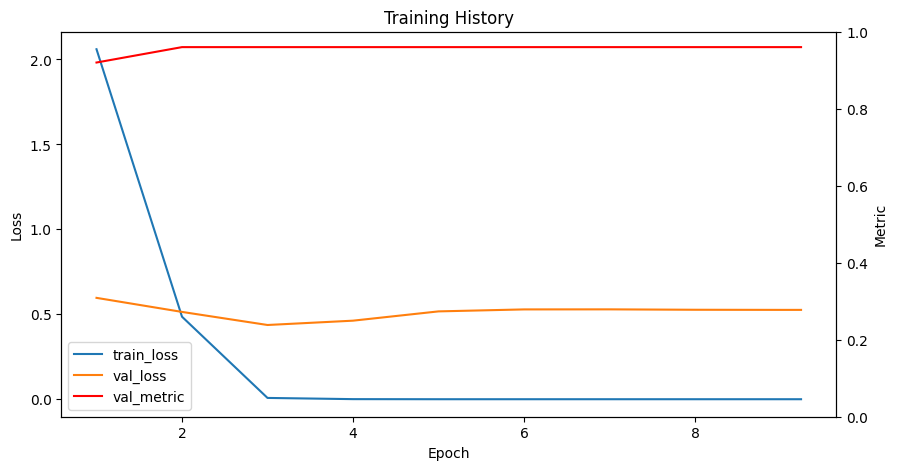

In [51]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in training_history if 'loss' in x]
val_loss = [x['eval_loss'] for x in training_history if 'eval_loss' in x]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in training_history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in training_history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in training_history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in training_history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss[0:10], label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs, metric[0:10], color='red', label='val_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

plt.title("Training History")
plt.show()

In [33]:
#@title Short summary of model evaluation scores
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.4369618594646454, 'eval_accuracy': 0.96, 'eval_runtime': 6.5183, 'eval_samples_per_second': 3.835, 'eval_steps_per_second': 0.307, 'epoch': 9.24}


In [ ]:
#@title Example how Accuracy metric is calculated with `evaluate` library (also from HuggingFace)
predictions = [0, 1, 2, 0, 1]  # Model's predictions
labels = [0, 1, 1, 0, 2]  # True labels
metric = load("accuracy")
accuracy_score = metric.compute(predictions=predictions, references=labels)
print(accuracy_score)

In [ ]:
#@title Clear GPU memory manually
import gc
gc.collect()
torch.cuda.empty_cache()

## Save and Load the finetuned model

In [54]:
def save_model(model,filepath):
    '''Saves all parameters that were changed during finetuning ("non-frozen" parameters)'''

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param.detach().cpu()

    # Save only the finetuned parameters
    torch.save(non_frozen_params, filepath)


def load_model(filepath, num_labels=1):
    '''Creates a new instance of the original pre-trained Synthyra/ESMplusplus_large 600M model and
    loads the finetuned weights from a file'''

    # Load a new model and tokenizer
    config = AutoConfig.from_pretrained('Synthyra/ESMplusplus_large', trust_remote_code=True, num_labels=3)
    model_classification = AutoModelForSequenceClassification.from_pretrained('Synthyra/ESMplusplus_large', trust_remote_code=True, config=config)
    tokenizer = model_classification.tokenizer

    # Load the non-frozen parameters (the finetuned model) from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            # .data attribute refers to the underlying tensor containing the param data, modifying it directly modifies the tensor within the model.
            param.data = non_frozen_params[param_name].data

    return tokenizer, model


This saves only the finetuned (non-frozen parameters) weights to a .pth file

It is a 50 MB File, while the entire model would be around 2.4 GB

In [53]:
save_model(model,"/content/drive/My Drive/LLMs_data/models_checkpoint/ESMplusplus_large_600M_finetuned_plastic_polymers_pident50_len550_nr_small_v1.pth")

## Load a finetuned model from file
To load the weights again, we initialize a new pre-trained model from the pretrained checkpoint and load the LoRA weights afterwards

You need to specifiy the correct num_labels!

In [55]:
tokenizer, model_reload = load_model("/content/drive/My Drive/LLMs_data/models_checkpoint/ESMplusplus_large_600M_finetuned_plastic_polymers_pident50_len550_nr_small_v1.pth",
                                     num_labels=3)

Some weights of ESMplusplusForSequenceClassification were not initialized from the model checkpoint at Synthyra/ESMplusplus_large and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-54-9469e1ec62f2>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via thi

Check if the original and the reloaded models are identical by comparing their weights

In [57]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


## Test results of the model's classification ability
The mapping of the labels to the plastic type:
{'PET': 0, 'PLA': 1, 'PE': 2}

In [90]:
#@title Predict the protein class (plastic degrading enzymes - PET/PE/PLA) from a set of sequences + labels (using batches)

def predict_on_test_set_batch(model, test_set, tokenizer):
    """
    Makes predictions on a test dataset using a loaded model.
    Also preprocesses the sequences according to how the model was trained (remove uncommon AAs, * and pad with spaces between AAs).

    Args:
        model: The loaded model.
        test_set: The test dataset as a pandas DataFrame with 'sequence' and 'label' columns.
        tokenizer: The tokenizer used for the model.

    Returns:
        A list of predictions, probabilites and raw logits.
    """

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    torchdataset_test = StringLabelDatasetFromHF(test_set)
    test_dataloader = DataLoader(torchdataset_test, batch_size=8, collate_fn=data_collator)

    # Put the model in evaluation mode
    model.eval()

    logits = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            logits += model(input_ids, attention_mask=attention_mask).logits.tolist()

    probs = F.softmax(torch.tensor(logits), dim=-1)
    predictions = np.array(logits).argmax(axis=1) # predictions = [item.argmax() for item in np.array(logits)]

    return predictions, probs, logits


In [91]:
predictions, probs, logits = predict_on_test_set_batch(model, my_test[0:25], tokenizer)

  0%|          | 0/4 [00:00<?, ?it/s]

In [92]:
print(predictions)
print(probs)
print(logits)

[0 0 0 1 0 0 2 0 2 0 2 0 0 0 0 0 0 1 0 1 0 0 0 2 0]
tensor([[9.9974e-01, 2.5752e-04, 3.8730e-13],
        [9.9927e-01, 7.2782e-04, 6.2504e-10],
        [9.6743e-01, 3.2570e-02, 2.0008e-11],
        [1.7805e-05, 9.9998e-01, 9.8845e-07],
        [9.8653e-01, 1.3472e-02, 4.8458e-11],
        [9.9993e-01, 7.3461e-05, 6.2129e-12],
        [2.3868e-16, 7.7371e-10, 1.0000e+00],
        [9.9003e-01, 9.9675e-03, 4.7106e-14],
        [2.0252e-20, 1.2549e-12, 1.0000e+00],
        [9.9879e-01, 1.2083e-03, 1.9771e-11],
        [1.0781e-15, 5.2448e-09, 1.0000e+00],
        [9.9839e-01, 1.6121e-03, 7.2440e-13],
        [7.5555e-01, 2.4445e-01, 4.3571e-10],
        [9.9775e-01, 2.2481e-03, 1.8686e-14],
        [9.0988e-01, 9.0121e-02, 5.8185e-12],
        [9.8048e-01, 1.9524e-02, 8.3948e-14],
        [9.9996e-01, 3.5878e-05, 3.7784e-14],
        [4.6038e-05, 9.9995e-01, 6.8596e-07],
        [9.9993e-01, 6.6848e-05, 5.9042e-13],
        [2.2483e-05, 9.9997e-01, 7.2838e-06],
        [9.9997e-01, 2.6361e

### The model's classification accuracy on the test set

In [93]:
print("Accuracy: ", accuracy_score(my_test[0:25].label, predictions))

Accuracy:  1.0


In [80]:
#@title Process the fasta file to convert it to compatiable format with batch prediction (sequence+label)

# implemented using Bio module
def parse_fasta_to_df(fasta_path, keep_original_header=False):
  """Read in the fasta file, separate the headers from the sequences into df columns, and filter non-PET/PLA/PE types sequences."""
  seqs = {}
  for record in SeqIO.parse(fasta_path, "fasta"):
      seqs[record.description] = str(record.seq)
  print(f'Read {len(seqs)} sequences')

  # create a dataframe from the sequences dict
  proteins_df = pd.DataFrame(data={'seq_id': seqs.keys(), 'sequence': seqs.values()}, columns=['seq_id', 'sequence'])

  def _filter_plastic_types(value):
    """Filter out plastic types from a seq_id column string using set intersection (&) operation.
    This will keep only allowed types (PET, PLA, PE)"""
    extracted = {value.split("|")[0]}
    allowed = {"PET", "PLA", "PE"}  # Allowed values
    filtered = extracted & allowed  # Keep only allowed values

    if len(filtered) == 1:  # Keep only rows with exactly 1 valid entry
        return next(iter(filtered))  # Extract the single value, preferred way to fetch a single element from an iterable
    return None  # Drop rows with multiple or zero values

  if keep_original_header:
    proteins_df["original header"] = proteins_df["seq_id"]
  # Apply function and drop rows with None (filtered out)
  proteins_df["seq_id"] = proteins_df["seq_id"].apply(_filter_plastic_types)
  # Remove rows that were filtered out
  proteins_df = proteins_df.dropna().reset_index(drop=True)
  proteins_df.rename(columns={'seq_id': 'label'}, inplace=True)
  # convert the target polymers titles to integers
  proteins_df['label'] = proteins_df['label'].map({'PET': 0, 'PLA': 1, 'PE': 2})

  print(f'Kept {proteins_df.shape[0]} sequences')

  return proteins_df


In [82]:
input_seqs_from_db_path = "/content/drive/My Drive/LLMs_data/input_seq/Plastic_degrading_enzymes_PE_PET_PLA_PVA_targetDB_f.fasta"
input_seqs_from_db = parse_fasta_to_df(input_seqs_from_db_path)
input_seqs_from_db.head(10)

Read 200 sequences
Kept 175 sequences


,label,sequence
0,0,MKRKIIRGAMALFILLTMVITQSISVSAAASKFVTSVNTTSKVVAL...
1,0,MKQSKWYAFLSGAVLLTGIAVYGLWIGYQDIVNPPERTLSVSEDER...
2,0,MRKETAWFVGGAAIAAATAAGASVWSQYGSLVRWQEPELPIQPTTR...
3,0,MLHYKTYTISDDHPWVIFIHGAGGSLSHWYRQLRPFRKKYNVLLVD...
4,0,MMGYITAHDGTNLYVEDVGFGEPIVFLHGWPANNNMFEYQKNALVE...
5,2,MQTQDQRLLIVDDDEMFCHVLSRALTRRGFEVQVAHDADQAMTLIT...
6,2,MPPFRSSRWLSGGHVQTLYSPLWRASPQLQRRRERMTLQDGDFIDL...
7,2,MVPTTVDFDTLCPEPIFQDRWVATPRGRVFTRTWETSHLRSDVPIV...
8,2,MFRFHIVSALLTLFIAVPSQAHDVGQREIKISGAEPGRNLEVSVWY...
9,2,MIRNATAVSVDQHELAATVISPDTTIPGVLFLHGWAGSQERDIERA...


### The model's classification accuracy on an independent set (Plastic degrading proteins DB)
Let's take all (or most) of the sequences in the Plastic degrading enzymes DB and try the model's prediction ability on them.

It will give an additional info about its classification ability in a more generalized sense, as these sequences were manually curated and validated, while all the train-val-test dataset sequences are directly from metagenomic data and their labels were assigned by homology search (in a sense these labels are predicted).

In [94]:
predictions, probs, logits = predict_on_test_set_batch(model, input_seqs_from_db, tokenizer)

  0%|          | 0/22 [00:00<?, ?it/s]

In [97]:
print("Accuracy: ", accuracy_score(input_seqs_from_db.label, predictions))

Accuracy:  0.8285714285714286
